
<p style="text-align:center;">
<img src="https://f9c22e342c4dee41182f-95e42b8de37d1835f9756e789fbdcf70.ssl.cf1.rackcdn.com/86486757_00010355_1443106466-playlist.png"
     alt="DigitalFuturesLogo"
     style="float: center; margin-right: 10px;" />
</p>


# Find my perfect Airbnb

##### A data analytics project which creates an advanced filtering function to make finding your perfect Airbnb much easier. Motivation for this project stems from the often overwhelming number of Airbnb options, even after traditional filters such as price and number of beds. I wanted to streamline a users Airbnb search by analysing themes within the listing descriptions and reviews of Airbnbs. My final function allows the user to select Airbnb options based on features such as cozy, spacious and quiet.

##### This project uses natural language processing and unsupervised learning models on a large data set from kaggle, containing Airbnb listings/reviews in Amsterdam. Methods used include K-means clustering and Topic Modelling.

## Import Packages


In [235]:
import pandas as pd
import numpy as np

import os
import itertools
from collections import Counter
import re
import string

#NLP
import nltk 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import opinion_lexicon
#Modelling
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

from wordcloud import WordCloud
import matplotlib.pyplot as plt

from collections import Counter

from gensim import corpora, models
import pyLDAvis ## Purely a visualisation library
import pyLDAvis.gensim_models as gensimvis
from pprint import pprint

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from PIL import Image

from IPython.core.display import HTML

In [236]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('afinn')
nltk.download('opinion_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ollie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ollie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ollie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ollie\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Error loading afinn: Package 'afinn' not found in index
[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     C:\Users\ollie\AppData\Roaming\nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


True

## 1. Load Data Sets

In [237]:
pd.set_option('display.max_columns', None) # view all columns

In [238]:
reviews = pd.read_csv('reviews_details.csv') # read in reviews data set

In [239]:
listings = pd.read_csv("listings_details.csv") # read in listings data set



KeyboardInterrupt



## 2. Data Checks

## 2.1 Listings Data Checks

In [ ]:
listings.shape # check shape of data set

In [ ]:
listings.head(3) # check first 3 rows

In [ ]:
# listings.info() # check for nulls

In [ ]:
len(listings['id'].unique()) # check all listing ids are unique

## 2.2 Reviews Data Checks


In [ ]:
reviews.shape 

In [ ]:
reviews.head(3)

In [ ]:
reviews.isnull().sum() # check for nulls

In [ ]:
len(reviews['listing_id'].unique()) # check unique listing IDs in data set

#### There are 2406 listings with no reviews.

## 3. Natural Language Processing

In [ ]:
bi_gram_words = ['no', 'not', "didn't", "wasn't", "weren't", "won't"] # list of words which could add value eg('not clean')

In [ ]:
stpwrd = nltk.corpus.stopwords.words('english') # list of stop words
stpwrd.extend(string.punctuation) # add punctuation to list

In [ ]:
stpwrd = [word for word in stpwrd if word not in bi_gram_words] # remove potential value words from stop words

In [ ]:
# Common words in data sets which don't add value:
no_value_words = ['apartment', 'amsterdam', 'room', 'kitchen', 'city', 'house', 'bedroom', 'living',
                  'bathroom', 'bed', 'located', 'area', 'floor',  'minutes', '2', '\'s', 
                  'nice', 'one', 'centre', 'restaurants', 'two', 'center', 'great', 'close', 'also', 
                  'place', 'de', 'walk',  'stay', 'pijp' , 'offer', 'en', 'may', 'take', 'geust', 'day',
                   'walking', 'station', 'equipped', 'home', 'fully', 
                  'central',  'enjoy', 'around', 'shower', 'perfect', 'double', 'tram',
                  'distance', 'toilet', 'bars', 'bedrooms', 'min', '10', 'need', 'away', 'street',
                   'public', '1', '5', 'free', 'corner', 'open', 'vondelpark', 'shops',
                  'find',   'neighborhood', 'canal', 'within', 'everything', 'terrace', 
                   'available', 'access', 'square', 'situated', '’', 'near', 'neighbourhood',
                  'space', 'transport', 'like', 'tv', 'location',  'jordaan', '3', 'coffee', 'dining',
                   'curfew', 'lots', 'table', 'building', 'dam', 'back', 'dutch', 'extra' , 'schip', 'connection', 'wi-fi','lot']

In [ ]:
# Function to clean text using regex.
def regex_clean(txt, regex):    
    if isinstance(txt, str):
        return " ".join(re.sub(regex, " ", str(txt)).split())
    else:
        return txt

In [ ]:
# Function to apply appropiate regex and remove capitilisation.
def pre_token_cleaning(df, column_name):
    df = df.copy()
    df[column_name] = df[column_name].apply(lambda x: regex_clean(x, r'\s\d+\s')) # remove digits
    df[column_name] = df[column_name].apply(lambda x: regex_clean(x, r'\b\w*\d\w*\b')) # remove digits surrounded by letters
    df[column_name] = df[column_name].astype(str).str.lower()
    return df

In [ ]:
# Function which removes no value words and tokenizes.
def tokenization(df, column_name):
    df = df.copy()
    df[column_name] = df[column_name].apply(word_tokenize)
    df[column_name] = df[column_name].apply(lambda x: [word for word in x if word not in stpwrd])
    df[column_name] = df[column_name].apply(lambda x: [word for word in x if word not in no_value_words])
    
    return df
    

In [ ]:
porter = PorterStemmer() # intiate stemmer

In [ ]:
# Uses porter stemmer.
def final_prep(df, column_name):
    df = df.copy()
     # Post Token Cleaning - Stuff that applies to a list
    df[column_name] = df[column_name].apply(lambda x: [porter.stem(word) for word in x ])
    
    return df



In [ ]:
# Combination of previous functions:
def prep_data(df, column_name):
    
    df = df.copy()
   
    # Pre Token Cleaning - Stuff that applies to a string.
    df[column_name] = df[column_name].apply(lambda x: regex_clean(x, r'\s\d+\s'))
    df[column_name] = df[column_name].apply(lambda x: regex_clean(x, r'\b\w*\d\w*\b'))
    df[column_name] = df[column_name].astype(str).str.lower()
    
    
    # Tokenise
    df[column_name] = df[column_name].apply(word_tokenize)
    
       
    # Post Token Cleaning - Stuff that applies to a list
    df[column_name] = df[column_name].apply(lambda x: [word for word in x if word not in stpwrd])
    df[column_name] = df[column_name].apply(lambda x: [word for word in x if word not in no_value_words])
    df[column_name] = df[column_name].apply(lambda x: [porter.stem(word) for word in x ])
    
    return df

In [ ]:
# Function to create bi_grams:
def bi_grams(df, column_name, words_to_combine):
    combined_tokens = []
    for tokens in df[column_name]:
        new_tokens = []
        i = 0
        while i < len(tokens):
            if tokens[i] in words_to_combine:
                if i + 1 < len(tokens):
                    new_tokens.append(tokens[i] + ' ' + tokens[i + 1])
                    i += 2
                else:
                    new_tokens.append(tokens[i])
                    i += 1
            else:
                new_tokens.append(tokens[i])
                i += 1
        combined_tokens.append(new_tokens)
    return combined_tokens

## 3.1 Natural Language Processing of Listings Data Set


In [ ]:
listings.fillna(' ', inplace =True) # fill nulls with empty strings

In [ ]:
listings['Complete Description'] = listings['name'] +' '+ listings['summary'] + ' ' +  listings['space'] + ' ' + listings['description'] # combine columns to create a complete description

In [ ]:
listings[['Complete Description']].head(3)

In [ ]:
listings_pre_token = pre_token_cleaning(listings,'Complete Description')


In [ ]:
listings_tokens = tokenization(listings_pre_token, 'Complete Description')


In [ ]:
listings_final = final_prep(listings_tokens, 'Complete Description')

In [ ]:
listings_prep = prep_data(listings, 'Complete Description')

In [ ]:
listings_prep[['Complete Description']].head(3) # 

In [ ]:
processed_column = bi_grams(listings_prep,'Complete Description', ['no' , 'not'])
listings_prep['Complete Description'] = processed_column

In [ ]:
listings_prep[['Complete Description']].head(3)

## 3.2 Natural Language Processing of Reviews Data Set

In [ ]:
reviews_prep = prep_data(reviews,'comments')

In [ ]:
bi_gram_column = bi_grams(reviews_prep,'comments', ['no' , 'not'])
reviews_prep['comments'] = bi_gram_column

In [ ]:
reviews_prep[['comments']].head(3)

## 4. Exploring Key Trends

In [ ]:
# Function to count most common words
def count_most_common_words(df, column_name, num_words, filter_no_value_words=False):
    most_common_words = None

    # Check if input is already tokenized
    if isinstance(df[column_name][0], str):
        # Tokenize the string and flatten the list of words
        all_words = [word for comment in df[column_name] for word in word_tokenize(comment)]
    elif isinstance(df[column_name][0], list):
        # Flatten the list of lists of words
        all_words = [word for word_list in df[column_name] for word in word_list]
    else:
        print("Unsupported data format in the column")
        return most_common_words

    # Always filter out stopwords
    all_words = [word.lower() for word in all_words if word.lower() not in stpwrd]

    # Filter out no_value_words if specified
    if filter_no_value_words:
        all_words = [word.lower() for word in all_words if word.lower() not in no_value_words]

    # Count the occurrences of each word
    word_counts = Counter(all_words)

    # Find the most common words
    most_common_words = word_counts.most_common(num_words)

    return most_common_words

In [ ]:
count_most_common_words(listings_prep,'Complete Description', 10)

In [ ]:
def generate_word_cloud(word_freq_list, mask_path, rotate_mask=False):
    # Load the mask image
    mask = Image.open(mask_path)

    # Rotate the mask image if specified
    if rotate_mask:
        mask = mask.rotate(180)

    # Create a dictionary from the list of tuples
    word_freq_dict = dict(word_freq_list)

    # Generate the word cloud with rotated mask and darker red color scheme
    wordcloud = WordCloud(width=800, height=400, background_color='grey', mask=np.array(mask),
                          colormap='Reds_r').generate_from_frequencies(word_freq_dict)

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

    return wordcloud

In [ ]:
house_cloud = generate_word_cloud(count_most_common_words(listings_tokens,'Complete Description', 50, True), "simple-house.png")
house_cloud.to_file('house_cloud.png')

In [ ]:
thumbs_down_cloud = generate_word_cloud(count_most_common_words(listings_pre_token,'Complete Description', 50, False), "thumb_down.png", rotate_mask = True)
thumbs_down_cloud.to_file('thumbs_down_cloud.png')


## 5. Simplistic Model

## 5.1 Divide Listings into Categories

In [ ]:
def assign_group_name(row):
    group_words = {
        'Cozy': ['studio','cosi', 'cozi'],
        'Spacious': ['spaciou', 'large', 'big'],
        'Quiet': ['quiet', 'garden', 'view'],
        'Comfortable': ['comfort','relax','warm','modern'],
        'Dutch': ['van', 'een','het']
    }

    word_counts = {group: sum(1 for word in group_words[group] if word in row) for group in group_words}
    max_group = max(word_counts, key=word_counts.get)
    return max_group

def create_dataframe_and_assign_groups(df, column):
    # Apply the function to create a new column with group names
    df = df.copy()
    df['Model_1'] = df[column].apply(assign_group_name)
    return df

In [ ]:
listings_prep = create_dataframe_and_assign_groups(listings_prep, 'Complete Description')

In [ ]:
listings_prep['Model_1'].value_counts()

## 5.2 Divide Reviews into Categories

In [ ]:
# Assigns listings a group based on appearance of words
def assign_groups_reviews(row):
    group_1_words = ['no clean', 'not clean', 'dirty', 'gross', 'bad','not good','not nice']
   
    group_1 = any(word in row for word in group_1_words)
    
    # Assign rows not matching any specified words to group 2
    if not group_1:
        group_2 = True
    else:
        group_2 = False

    return group_1, group_2

In [ ]:
def create_dataframe_and_assign_groups_reviews(df, column):
    # Apply the function to create new columns
    df['Not clean'], df['Clean'] = zip(*df[column].apply(assign_groups_reviews))

    return df

In [ ]:
reviews_grouped = create_dataframe_and_assign_groups_reviews(reviews_prep, 'comments')

In [ ]:
dirty_reviews = reviews_grouped[reviews_grouped['Not clean'] == True]
    
    # Group by listing_id and count occurrences of 'True' in 'Not clean' column
dirty_count = dirty_reviews.groupby('listing_id')['Not clean'].value_counts()
dirty_count

In [258]:
filtered_reviews = reviews_grouped[reviews_grouped['Not clean'] == False]
filtered_reviews.shape

(427591, 9)

In [ ]:
def calculate_score(df, column_name, score):
    # Group by listing_id and calculate the mean of specified column
    
    df[f'{score}_score'] = df.groupby('listing_id')[column_name].transform('sum')

    
    # Scale the 'Dirty_score' column
    df[f'{score}_score']  = df[f'{score}_score']  / df[f'{score}_score'] .max()
    
    # Sort the DataFrame by 'Dirty_score' in descending order
    # df = df.sort_values(by=f'{score}_score', ascending=False)
    
    # Drop duplicate listing_id rows
    df_unique = df.drop_duplicates(subset='listing_id')
    
    return df_unique


In [246]:
df_scores = calculate_score(reviews_grouped, 'Not clean', 'Dirty')
df_scores.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,Not clean,Clean,Dirty_score
0,2818,1191,2009-03-30,10952,Lam,"[daniel, realli, cool, clean, quiet, map, lone...",False,True,0.071429
248,3209,40482511,2015-07-31,11256559,Fiona,"[love, appart, level, plant, realli, enjoy, we...",False,True,0.000000
290,20168,28186,2010-03-02,70091,Justin,"[sasha, b, b, make, ideal, short, visit, might...",False,True,0.357143
523,25428,228847675,2018-01-21,43336597,Andrew,"[spaciou, clean, perfectli, cafe, facil, touri...",False,True,0.000000
524,27886,851027,2012-01-09,1008593,Wayne,"[excel, accommod, love, host, beauti, breakfas...",False,True,0.071429


In [ ]:
df_scores_sorted = df_scores.sort_values(by='Dirty_score', ascending = False)

In [241]:
df_scores_sorted.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,Not clean,Clean,Dirty_score
21802,392003,1500325,2012-06-17,33616,Chris,"[time, stay, agn, first, good, friendli, help,...",True,False,1.000000
92072,1835186,10781378,2014-03-07,11963837,Valerie,"[spent, realli, realli, time, actual, first, t...",False,True,0.857143
14270,239647,634800,2011-10-16,1278394,Brianna,"[harm, host, made, sure, knew, get, town, even...",False,True,0.785714
7808,82482,320921,2011-06-18,588248,Frank & Ann,"[shawna, nao, host, enjoy, meet, famili, would...",False,True,0.714286
100891,2125637,11424467,2014-04-01,13711539,Alan,"[reserv, cancel, day, arriv, autom, post]",False,True,0.714286


In [256]:
# Define the bins and labels
bins = [-0.01, 0.0, 0.1, 0.4, 1]
labels = ['Very Clean', 'Slightly dirty', 'Dirty', 'Avoid at all costs']

# Create the new column based on the 'Dirty_score' ranges
df_scores['Dirty_category'] = pd.cut(df_scores['Dirty_score'], bins=bins, labels=labels, include_lowest=True)
df_scores['Dirty_category'].value_counts()

C:\Users\ollie\AppData\Local\Temp\ipykernel_18068\2090894167.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scores['Dirty_category'] = pd.cut(df_scores['Dirty_score'], bins=bins, labels=labels, include_lowest=True)


Dirty_category
Very Clean            14894
Slightly dirty         1930
Dirty                   752
Avoid at all costs       48
Name: count, dtype: int64

In [261]:
df_scores2 = df_scores[df_scores['Not clean'] == True]

# Count the values in the filtered DataFrame
value_counts = df_scores2['Dirty_category'].value_counts()

# Print the value counts
print(value_counts)

Dirty_category
Slightly dirty        124
Dirty                  21
Avoid at all costs      2
Very Clean              0
Name: count, dtype: int64


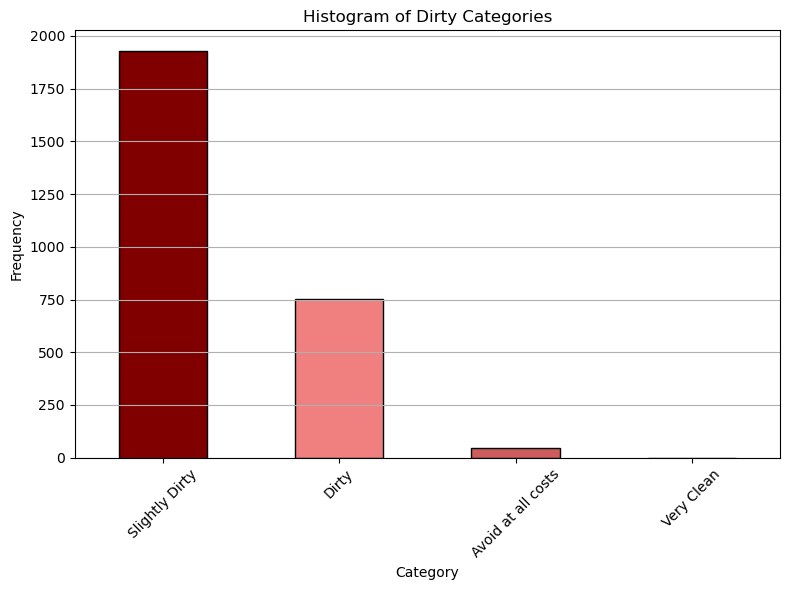

In [264]:

# Get the counts of each category
category_counts = filtered_df['Dirty_category'].value_counts()

# Define colors for each category
colors = ['maroon', 'lightcoral', 'indianred']

# Plot the histogram
plt.figure(figsize=(8, 6))
category_counts.plot(kind='bar', color=colors, edgecolor='black')  # Change color to list of colors
plt.title('Histogram of Dirty Categories')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid(axis='y')  # Show gridlines on y-axis only
plt.tight_layout()
plt.savefig('Histogram.png', dpi=300)# Adjust layout to prevent clipping of labels
plt.show()

## 6 Topic Modelling

In [164]:
def topic_modeling(df, column, num_topics=5, passes=10):
    df =df.copy()
    # Create dictionary and document-term matrix
    dictionary = corpora.Dictionary(df[column])
    corpus = [dictionary.doc2bow(text) for text in df[column]]

    # Train LDA model
    lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=passes, random_state= 20)

    # Get the topic distribution for each document
    topics = [lda_model.get_document_topics(doc) for doc in corpus]

    # Count the number of occurrences in each topic
    topic_counts = {}
    for doc_topics in topics:
        for topic, prob in doc_topics:
            if topic not in topic_counts:
                topic_counts[topic] = 1
            else:
                topic_counts[topic] += 1
                
    # Visualization
    pyLDAvis.enable_notebook()
    prepared_data = gensimvis.prepare(lda_model, corpus, dictionary)
    pyLDAvis.display(prepared_data)
    plt.show() 

    return lda_model, topic_counts



In [172]:
# Create dictionary and document-term matrix
dictionary = corpora.Dictionary(listings_prep['Complete Description'])
corpus = [dictionary.doc2bow(text) for text in listings_prep['Complete Description']]

In [165]:
topics, counts = topic_modeling(listings_prep.head(100), column='Complete Description')
pprint(topics.print_topics())
print(counts)


[(0,
  '0.012*"view" + 0.011*"privat" + 0.009*"machin" + 0.007*"spaciou" + '
  '0.007*"garden" + 0.007*"minut" + 0.007*"small" + 0.007*"comfort" + '
  '0.007*"park" + 0.006*"quiet"'),
 (1,
  '0.011*"privat" + 0.009*"spaciou" + 0.008*"larg" + 0.007*"bike" + '
  '0.007*"studio" + 0.006*"comfort" + 0.006*"new" + 0.006*"small" + '
  '0.006*"second" + 0.006*"park"'),
 (2,
  '0.015*"b" + 0.012*"quiet" + 0.009*"privat" + 0.009*"bike" + 0.008*"comfort" '
  '+ 0.007*"love" + 0.007*"includ" + 0.007*"museum" + 0.006*"room" + '
  '0.006*"view"'),
 (3,
  '0.014*"privat" + 0.010*"studio" + 0.010*"comfort" + 0.008*"★" + '
  '0.008*"internet" + 0.008*"best" + 0.007*"larg" + 0.007*"quiet" + '
  '0.007*"market" + 0.006*"old"'),
 (4,
  '0.012*"comfort" + 0.010*"houseboat" + 0.010*"wifi" + 0.010*"balconi" + '
  '0.007*"privat" + 0.007*"bright" + 0.006*"light" + 0.006*"quiet" + '
  '0.006*"beauti" + 0.006*"clean"')]
{1: 24, 2: 29, 0: 23, 4: 14, 3: 24}


In [183]:



#     # Train LDA model
# lda_model = models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=2, random_state= 20)

#     # Get the topic distribution for each document
# topics = [lda_model.get_document_topics(doc) for doc in corpus]

#     # Count the number of occurrences in each topic
# topic_counts = {}
# for doc_topics in topics:
#     for topic, prob in doc_topics:
#         if topic not in topic_counts:
#             topic_counts[topic] = 1
#         else:
#             topic_counts[topic] += 1
                
    # Visualization
pyLDAvis.enable_notebook(local = True)
prepared_data = gensimvis.prepare(lda_model, corpus, dictionary, R = 10)
pyLDAvis.display(prepared_data)
pyLDAvis.save_html(prepared_data, 'lda_result.html')
display(HTML('lda_result.html'))
 

In [182]:
# lda_display = gensimvis.prepare(topics, ## the model
#                                 corpus = corpus, ## the TF-IDF corpus
#                                 dictionary = dictionary, ## Our dictionary
#                                 #mds='mmds',
#                                 R=20, ## How many topics to show
#                                 n_jobs=-1, 
#                                 mds='mmds')

In [67]:
def create_dataframe_and_assign_groups(df, column):
    df = df.copy()
    dictionary = corpora.Dictionary(df[column])
    corpus = [dictionary.doc2bow(text) for text in df[column]]
    
    # Apply topic_modeling function
    lda_model, topic_counts = topic_modeling(df, column)

    # Get the most frequent topic for each document
    dominant_topics = [max(topics, key=lambda x: x[1])[0] for topics in lda_model.get_document_topics(corpus)]

    # Map topic numbers to topic names
    topic_mapping = {
        0: 'Comfortable',
        1: 'Quiet',
        2: 'Cozy',
        3: 'Spacious',
        4: 'Dutch'
    }

    # Create 'Group2' column based on the dominant topic for each document
    df['Model_2'] = [topic_mapping[topic] for topic in dominant_topics]

    return df

In [68]:
listings_prep = create_dataframe_and_assign_groups(listings_prep, 'Complete Description')

In [69]:
listings_prep.head(1)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,Complete Description,Model 1,Model_1,Model_2
0,2818,https://www.airbnb.com/rooms/2818,20181206172549,2018-12-06,Quiet Garden View Room & Super Fast WiFi,Quiet Garden View Room & Super Fast WiFi,I'm renting a bedroom (room overlooking the ga...,Quiet Garden View Room & Super Fast WiFi I'm r...,none,"Indische Buurt (""Indies Neighborhood"") is a ne...",From week 38 to week 47 maintenance work to th...,The neighbourhood is well served by 24 hours p...,,,Please: - Leave your shoes in the entrance - ...,,,https://a0.muscache.com/im/pictures/10272854/8...,,3159,https://www.airbnb.com/users/show/3159,Daniel,2008-09-24,"Amsterdam, Noord-Holland, The Netherlands","Upon arriving in Amsterdam, one can imagine as...",within an hour,100%,,t,https://a0.muscache.com/im/users/3159/profile_...,https://a0.muscache.com/im/users/3159/profile_...,Indische Buurt,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,f,"Amsterdam, North Holland, Netherlands",Indische Buurt,Oostelijk Havengebied - Indische Buurt,,Amsterdam,North Holland,,Amsterdam,"Amsterdam, Netherlands",NL,Netherlands,52.365755,4.941419,f,Apartment,Private room,2,1.5,1.0,2.0,Real Bed,"{Internet,Wifi,""Paid parking off premises"",""Bu...",,$59.00,,"$1,500.00",$100.00,$50.00,1,$20.00,3,15,today,t,17,44,44,44,2018-12-06,248,2009-03-30,2018-11-28,97.0,10.0,10.0,10.0,10.0,9.0,10.0,f,,{Amsterdam},t,f,strict_14_with_grace_period,f,f,1,2.1,"[quiet, garden, view, super, fast, wifi, quiet...",Quiet Airbnb,Quiet,Spacious


## 7. K-means Clustering

In [229]:
def unsupervised_clustering(df, column, num_clusters=5):
    df = df.copy()
    # Convert lists of tokens to strings
    df[column] = df[column].apply(lambda tokens: ' '.join(tokens))

    # Vectorize the text data using TF-IDF
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(df[column])

    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=2)
    X_reduced = pca.fit_transform(X.toarray())

    # Apply K-means clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=30)
    kmeans.fit(X)

    # Get cluster labels
    cluster_labels = kmeans.labels_

    # Map cluster labels to group names
    group_mapping = {
        0: 'Cozy',
        1: 'Spacious',
        2: 'Quiet',
        3: 'Dutch',
        4: 'Comfortable'
        # Add more mappings if needed
    }

    # Assign group names based on cluster labels
    group_names = [group_mapping[label] for label in cluster_labels]

    # Add group names as a new column in the DataFrame
    df['Model_3'] = group_names

    # Get unique cluster labels and corresponding group names
    unique_labels = sorted(set(cluster_labels))
    legend_labels = [group_mapping[label] for label in unique_labels]

    # Get unique colors from the plot (red/pink color scheme)
    unique_colors = ['red', 'rosybrown', 'salmon', 'maroon', 'chocolate'][:num_clusters]

    # Create legend handles with correct colors
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in unique_colors]

    # Visualize the clusters
    plt.figure(figsize=(8, 6))
    for label, color in zip(unique_labels, unique_colors):
        plt.scatter(X_reduced[cluster_labels == label, 0], X_reduced[cluster_labels == label, 1], label=group_mapping[label], color=color, alpha=0.5)

    plt.legend(handles=legend_handles, labels=legend_labels, loc='best')
    plt.title('Cluster Visualization')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
     # Set background color to light grey
    plt.savefig('cluster_visualization.png', dpi=300)  # Save the figure

    plt.show()

    return df['Model_3'], kmeans, cluster_labels

C:\Users\ollie\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


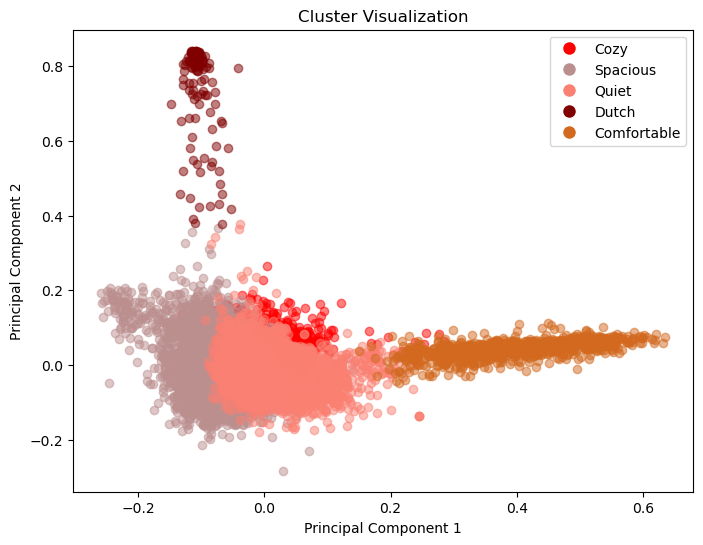

In [230]:
listings_prep['Model_3'],kmeans_model, cluster_labels = unsupervised_clustering(listings_prep, 'Complete Description')

In [231]:
def get_most_common_words_in_clusters(df, column, cluster_labels, num_words=10):
    # Create a DataFrame containing the text and cluster labels
    df_clustered = pd.DataFrame({column: df[column], 'cluster_label': cluster_labels})

    # Initialize a dictionary to store the most common words in each cluster
    most_common_words_per_cluster = {}

    # Iterate over each cluster
    for cluster_label in df_clustered['cluster_label'].unique():
        # Filter the DataFrame to contain only the documents belonging to the current cluster
        cluster_df = df_clustered[df_clustered['cluster_label'] == cluster_label]

        # Concatenate the text from all the documents in the cluster into a single string
        concatenated_text = ' '.join(' '.join(doc) for doc in cluster_df[column])

        # Tokenize the concatenated text
        tokens = CountVectorizer().build_tokenizer()(concatenated_text)

        # Count the occurrences of each word
        word_counts = pd.Series(tokens).value_counts()

        # Get the most common words in the cluster
        most_common_words_per_cluster[cluster_label] = word_counts.head(num_words)

    return most_common_words_per_cluster


In [87]:
most_common_words_in_clusters = get_most_common_words_in_clusters(listings_prep, 'Complete Description', cluster_labels)
for cluster_label, words in most_common_words_in_clusters.items():
    print(f"Cluster {cluster_label}: {words}")

Cluster 2: quiet      7207
beauti     7018
love       6966
spaciou    6541
privat     6455
balconi    6414
park       6295
view       5795
bike       5719
museum     5702
Name: count, dtype: int64
Cluster 1: spaciou    12858
garden      9684
larg        9637
comfort     9190
modern      8255
balconi     8105
big         6830
light       5940
beauti      5885
famili      5753
Name: count, dtype: int64
Cluster 0: studio     5424
privat     1395
comfort     836
small       677
quiet       595
beauti      572
cozi        532
cosi        528
love        523
view        523
Name: count, dtype: int64
Cluster 4: een       4647
het       4403
met       3263
van       3181
op        2208
je        1705
voor      1645
appart    1587
mijn      1179
ruimt      970
Name: count, dtype: int64
Cluster 3: featur     862
comfort    622
make       617
delici     587
sleep      577
fantast    556
fit        544
warm       319
invit      310
mind       308
Name: count, dtype: int64


## 8. Advanced Filter

In [232]:
listings_prep['Compare'] = listings_prep['Model_2'] == listings_prep['Model_3']

In [233]:
matching_count = listings_prep['Compare'].sum()

# Total number of entries
total_entries = len(listings_prep)

# Calculate the percentage of matching entries
percentage_matching = (matching_count / total_entries) * 100

print("Percentage of matching entries:", percentage_matching)

Percentage of matching entries: 58.83175237144284


In [96]:
listings_prep.head(1)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,Complete Description,Model 1,Model_1,Model_2,Model_3,Compare
0,2818,https://www.airbnb.com/rooms/2818,20181206172549,2018-12-06,Quiet Garden View Room & Super Fast WiFi,Quiet Garden View Room & Super Fast WiFi,I'm renting a bedroom (room overlooking the ga...,Quiet Garden View Room & Super Fast WiFi I'm r...,none,"Indische Buurt (""Indies Neighborhood"") is a ne...",From week 38 to week 47 maintenance work to th...,The neighbourhood is well served by 24 hours p...,,,Please: - Leave your shoes in the entrance - ...,,,https://a0.muscache.com/im/pictures/10272854/8...,,3159,https://www.airbnb.com/users/show/3159,Daniel,2008-09-24,"Amsterdam, Noord-Holland, The Netherlands","Upon arriving in Amsterdam, one can imagine as...",within an hour,100%,,t,https://a0.muscache.com/im/users/3159/profile_...,https://a0.muscache.com/im/users/3159/profile_...,Indische Buurt,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,f,"Amsterdam, North Holland, Netherlands",Indische Buurt,Oostelijk Havengebied - Indische Buurt,,Amsterdam,North Holland,,Amsterdam,"Amsterdam, Netherlands",NL,Netherlands,52.365755,4.941419,f,Apartment,Private room,2,1.5,1.0,2.0,Real Bed,"{Internet,Wifi,""Paid parking off premises"",""Bu...",,$59.00,,"$1,500.00",$100.00,$50.00,1,$20.00,3,15,today,t,17,44,44,44,2018-12-06,248,2009-03-30,2018-11-28,97.0,10.0,10.0,10.0,10.0,9.0,10.0,f,,{Amsterdam},t,f,strict_14_with_grace_period,f,f,1,2.1,"[quiet, garden, view, super, fast, wifi, quiet...",Quiet Airbnb,Quiet,Spacious,Cozy,False


In [133]:
def filter_by_preferences(df):
    filtered_df = df.copy()
    
    preferences = ['Quiet', 'Spacious', 'Cozy', 'Dutch', 'Comfortable']
    selected_preferences = []
    
    for preference in preferences:
        answer = input(f"Do you prefer {preference}? (yes/no): ").lower()
        if answer == 'yes':
            selected_preferences.append(preference)
    
    if not selected_preferences:
        print("No preference selected. Returning original DataFrame.")
        return filtered_df
    
    # Create a filter to check if 'Model_2' contains any of the selected preferences
    filter_condition = filtered_df['Model_2'].isin(selected_preferences)
    filtered_df = filtered_df[filter_condition]
    
    
    return filtered_df


In [267]:
filtered_df = filter_by_preferences(listings_prep);
filtered_df.head()


Do you prefer Quiet? (yes/no):  yes
Do you prefer Spacious? (yes/no):  no
Do you prefer Cozy? (yes/no):  yes
Do you prefer Dutch? (yes/no):  no
Do you prefer Comfortable? (yes/no):  not


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,Complete Description,Model 1,Model_1,Model_2,Model_3,Compare
1,3209,https://www.airbnb.com/rooms/3209,20181206172549,2018-12-06,"Quiet apt near center, great view",You will love our spacious (90 m2) bright apar...,"Our apartment has lots of light, a balcony and...",You will love our spacious (90 m2) bright apar...,none,Welcome to the Spaarndammerbuurt! From the beg...,,"From Central Station, walk towards the busstop...",You will have the entire house to yourself.,We will meet you in person for check in whenev...,"Our house comes with our very sweet, but old (...",,,https://a0.muscache.com/im/pictures/88955424/4...,,3806,https://www.airbnb.com/users/show/3806,Maartje,2008-10-24,"Amsterdam, Noord-Holland, The Netherlands",I am a freelance radio producer and journalist...,within an hour,100%,,f,https://a0.muscache.com/im/users/3806/profile_...,https://a0.muscache.com/im/users/3806/profile_...,Spaarndammer en Zeeheldenbuurt,1.0,1.0,"['email', 'phone', 'reviews', 'jumio']",t,t,"Amsterdam, Noord-Holland, Netherlands",Spaarndammer en Zeeheldenbuurt,Westerpark,,Amsterdam,Noord-Holland,1013 XE,Amsterdam,"Amsterdam, Netherlands",NL,Netherlands,52.390225,4.873924,t,Apartment,Entire home/apt,5,1.0,2.0,2.0,Real Bed,"{Internet,Wifi,Kitchen,""Paid parking off premi...",,$160.00,$543.00,"$2,000.00",$300.00,$40.00,2,$15.00,4,20,7 weeks ago,t,0,0,0,47,2018-12-06,42,2015-07-31,2018-08-29,96.0,10.0,9.0,10.0,10.0,9.0,9.0,f,,{Amsterdam},f,f,moderate,f,f,1,1.03,"[quiet, apt, view, love, spaciou, bright, monu...",Cozy,Quiet,Quiet,Quiet,True
2,20168,https://www.airbnb.com/rooms/20168,20181206172549,2018-12-06,100%Centre-Studio 1 Private Floor/Bathroom,"Cozy studio on your own private floor, 100% in...",For those who like all facets of city life. In...,"Cozy studio on your own private floor, 100% in...",none,Located just in between famous central canals....,Check-in time from 2pm till 10pm Checkout anyt...,No need to use any transport! All is within a ...,,"No curfew, free entrance 27/7 with your own ke...",This studio/room takes entire floor and has it...,,,https://a0.muscache.com/im/pictures/69979664/3...,,59484,https://www.airbnb.com/users/show/59484,Alex,2009-12-02,"Amsterdam, Noord-Holland, The Netherlands",Secondary phone nr. + (Phone number hidden by ...,within a few hours,100%,,f,https://a0.muscache.com/im/pictures/user/579c8...,https://a0.muscache.com/im/pictures/user/579c8...,Grachtengordel,2.0,2.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,f,"Amsterdam, North Holland, Netherlands",Grachtengordel,Centrum-Oost,,Amste

In [268]:
listings_prep_copy = listings_prep

In [269]:
df_scores

,listing_id,id,date,reviewer_id,reviewer_name,comments,Not clean,Clean,Dirty_score,Dirty_category
0,2818,1191,2009-03-30,10952,Lam,"[daniel, realli, cool, clean, quiet, map, lone...",False,True,0.071429,Slightly dirty
248,3209,40482511,2015-07-31,11256559,Fiona,"[love, appart, level, plant, realli, enjoy, we...",False,True,0.000000,Very Clean
290,20168,28186,2010-03-02,70091,Justin,"[sasha, b, b, make, ideal, short, visit, might...",False,True,0.357143,Dirty
523,25428,228847675,2018-01-21,43336597,Andrew,"[spaciou, clean, perfectli, cafe, facil, touri...",False,True,0.000000,Very Clean
524,27886,851027,2012-01-09,1008593,Wayne,"[excel, accommod, love, host, beauti, breakfas...",False,True,0.071429,Slightly dirty
...,...,...,...,...,...,...,...,...,...,...
431825,30435529,355474875,2018-12-04,131376847,Andy,"[host, cancel, reserv, arriv, autom, post]",False,True,0.000000,Very Clean
431826,30439111,355041813,2018-12-02,103201416,Mohammed,"[host, cancel, reserv, day, arriv, autom, post]",False,True,0.000000,Very Clean
431827,30518120,355519016,2018-12-04,228738702,Valeriya,"[host, cancel, reserv, day, arriv, autom, post]",False,True,0.000000,Very Clean
431828,30525429,355658538,2018-12-05,111439550,Lucas,"[love, truli, incred, tie, taia, excel, host, ...",False,True,0.000000,Very Clean


In [273]:
# merged_df = listings_prep_copy.merge(df_scores[['listing_id', 'Dirty_category']], how='left', left_on='id', right_on='listing_id')

# # Drop the duplicate 'id' column
# merged_df.drop(columns='listing_id', inplace=True)
# # Not all listings have reviews so fill score with 0.
# merged_df.fillna(0)

In [271]:
merged_df['Dirty_category'] = merged_df['Dirty_category'].astype('category')

# Then, set the categories explicitly
merged_df['Dirty_category'] = merged_df['Dirty_category'].cat.add_categories([0])

# Now you can fill missing values with the new category
merged_df['Dirty_category'].fillna(0, inplace=True)

In [275]:
def filter_by_preferences2(df):
    filtered_df = df.copy()
    
    # Original preferences
    preferences = ['Quiet', 'Spacious', 'Cozy', 'Dutch', 'Comfortable']
    selected_preferences = []
    
    for preference in preferences:
        answer = input(f"Do you prefer {preference}? (yes/no): ").lower()
        if answer == 'yes':
            selected_preferences.append(preference)
    
    # Dirty categories
    labels = ['Very Clean', 'Slightly dirty', 'Dirty', 'Avoid at all costs']
    selected_labels = []
    
    for label in labels:
        answer = input(f"Do you prefer {label}? (yes/no): ").lower()
        if answer == 'yes':
            selected_labels.append(label)
    
    if not selected_preferences and not selected_labels:
        print("No preference selected. Returning original DataFrame.")
        return filtered_df
    
    # Create filters based on preferences and dirty categories
    preference_filter = filtered_df['Model_2'].isin(selected_preferences)
    label_filter = filtered_df['Dirty_category'].isin(selected_labels)
    
    # Apply filters
    if selected_preferences and selected_labels:
        filtered_df = filtered_df[preference_filter & label_filter]
    elif selected_preferences:
        filtered_df = filtered_df[preference_filter]
    elif selected_labels:
        filtered_df = filtered_df[label_filter]
    
    return filtered_df

In [281]:
filtered_df2 = filter_by_preferences2(merged_df);
filtered_df2.head()

Do you prefer Quiet? (yes/no):  yes
Do you prefer Spacious? (yes/no):  no
Do you prefer Cozy? (yes/no):  yes
Do you prefer Dutch? (yes/no):  no
Do you prefer Comfortable? (yes/no):  no
Do you prefer Very Clean? (yes/no):  yes
Do you prefer Slightly dirty? (yes/no):  no
Do you prefer Dirty? (yes/no):  no
Do you prefer Avoid at all costs? (yes/no):  no


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,Complete Description,Model 1,Model_1,Model_2,Model_3,Compare,Dirty_category
1,3209,https://www.airbnb.com/rooms/3209,20181206172549,2018-12-06,"Quiet apt near center, great view",You will love our spacious (90 m2) bright apar...,"Our apartment has lots of light, a balcony and...",You will love our spacious (90 m2) bright apar...,none,Welcome to the Spaarndammerbuurt! From the beg...,,"From Central Station, walk towards the busstop...",You will have the entire house to yourself.,We will meet you in person for check in whenev...,"Our house comes with our very sweet, but old (...",,,https://a0.muscache.com/im/pictures/88955424/4...,,3806,https://www.airbnb.com/users/show/3806,Maartje,2008-10-24,"Amsterdam, Noord-Holland, The Netherlands",I am a freelance radio producer and journalist...,within an hour,100%,,f,https://a0.muscache.com/im/users/3806/profile_...,https://a0.muscache.com/im/users/3806/profile_...,Spaarndammer en Zeeheldenbuurt,1.0,1.0,"['email', 'phone', 'reviews', 'jumio']",t,t,"Amsterdam, Noord-Holland, Netherlands",Spaarndammer en Zeeheldenbuurt,Westerpark,,Amsterdam,Noord-Holland,1013 XE,Amsterdam,"Amsterdam, Netherlands",NL,Netherlands,52.390225,4.873924,t,Apartment,Entire home/apt,5,1.0,2.0,2.0,Real Bed,"{Internet,Wifi,Kitchen,""Paid parking off premi...",,$160.00,$543.00,"$2,000.00",$300.00,$40.00,2,$15.00,4,20,7 weeks ago,t,0,0,0,47,2018-12-06,42,2015-07-31,2018-08-29,96.0,10.0,9.0,10.0,10.0,9.0,9.0,f,,{Amsterdam},f,f,moderate,f,f,1,1.03,"[quiet, apt, view, love, spaciou, bright, monu...",Cozy,Quiet,Quiet,Quiet,True,Very Clean
15,46386,https://www.airbnb.com/rooms/46386,20181206172549,2018-12-06,Cozy loft in central Amsterdam,River view loft in quiet street in hip neighbo...,Beautiful and comfortable apartment/loft in gr...,River view loft in quiet street in hip neighbo...,none,"De pijp is all about hip shops, cafes, restaur...",Pets are welcome,"Tram, Metro, Car2Go, Carrental.",Entire flat,"in case of problems or if you need help , I li...",Please don't disturb the neighbors.,,,https://a0.muscache.com/im/pictures/e2f85fb1-6...,,207342,https://www.airbnb.com/users/show/207342,Joost,2010-08-20,"Amsterdam, Noord-Holland, The Netherlands",Dutch Physician (Cosmetic doctor) living and w...,,,,f,https://a0.muscache.com/im/users/207342/profil...,https://a0.muscache.com/im/users/207342/profil...,De Pijp,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Amsterdam, North Holland, Netherlands",De Pijp,De Pijp - Rivierenbuurt,,Amsterdam,North Holland,1074 VM,Amsterdam,"Amsterdam, Netherlands"